# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed

# setting seed
set_seed()

1. Define the model class.

In [2]:
class MLP(nn.Module):

    def __init__(self, no_features, no_hidden, no_labels):
        super(MLP, self).__init__()
        self.mlp_stack = nn.Sequential(
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(128, no_labels),
            nn.Sigmoid()            
        )

    # YOUR CODE HERE
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [3]:
from common_utils import split_dataset, preprocess_dataset

def preprocess(df):
    # Split the dataset into training and testing sets (70:30 ratio)
    X_train, y_train, X_test, y_test = split_dataset(df, ['filename', 'label'], test_size=0.3, random_state=0)

    # Preprocess the training and testing datasets
    X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)
    
    return X_train_scaled, y_train, X_test_scaled, y_test

df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]

df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [4]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).long()

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    train_dataset = CustomDataset(X_train_scaled, y_train)
    test_dataset = CustomDataset(X_test_scaled, y_test)

    train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

2. Next, define the model, optimizer and loss function.

In [5]:
model = MLP(no_features=X_train_scaled.shape[1], no_hidden=128, no_labels=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [6]:
# YOUR CODE HERE
from common_utils import EarlyStopper

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, train_correct = 0, 0
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    
    train_loss /= num_batches
    train_correct /=size

    return train_loss, train_correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, test_correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            test_correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    test_correct /= size
    
    return test_loss, test_correct

epochs = 100
early_stopper = EarlyStopper(patience=3, min_delta=0)
tr_loss, tr_correct = [], []
te_loss, te_correct = [], []
for t in range(epochs):
    train_loss, train_correct = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_correct = test_loop(test_dataloader, model, loss_fn)
    
    tr_loss.append(train_loss), tr_correct.append(train_correct)
    te_loss.append(test_loss), te_correct.append(test_correct)
    
    
    print(f"Epoch {t+1}: Train_accuracy: {(100*train_correct):>0.2f}%, Train_loss: {train_loss:>8f}, Test_accuracy: {(100*test_correct):>0.2f}%, Test_loss: {test_loss:>8f}")
    
    if early_stopper.early_stop(test_loss): 
        print("Done!")
        break

C:\Users\kp27d\anaconda3\envs\pytorchenv\Lib\site-packages\torch\autograd\__init__.py:251: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1: Train_accuracy: 53.58%, Train_loss: 0.689476, Test_accuracy: 55.69%, Test_loss: 0.684449
Epoch 2: Train_accuracy: 57.38%, Train_loss: 0.678188, Test_accuracy: 57.38%, Test_loss: 0.674794
Epoch 3: Train_accuracy: 60.02%, Train_loss: 0.669694, Test_accuracy: 58.73%, Test_loss: 0.669581
Epoch 4: Train_accuracy: 61.86%, Train_loss: 0.654929, Test_accuracy: 59.48%, Test_loss: 0.664902
Epoch 5: Train_accuracy: 63.46%, Train_loss: 0.645073, Test_accuracy: 59.78%, Test_loss: 0.665327
Epoch 6: Train_accuracy: 64.60%, Train_loss: 0.635805, Test_accuracy: 61.42%, Test_loss: 0.654975
Epoch 7: Train_accuracy: 65.74%, Train_loss: 0.625850, Test_accuracy: 63.57%, Test_loss: 0.643069
Epoch 8: Train_accuracy: 67.06%, Train_loss: 0.617243, Test_accuracy: 62.35%, Test_loss: 0.646603
Epoch 9: Train_accuracy: 68.11%, Train_loss: 0.605073, Test_accuracy: 64.01%, Test_loss: 0.639474
Epoch 10: Train_accuracy: 69.16%, Train_loss: 0.599917, Test_accuracy: 64.79%, Test_loss: 0.630670
Epoch 11: Train_acc

#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


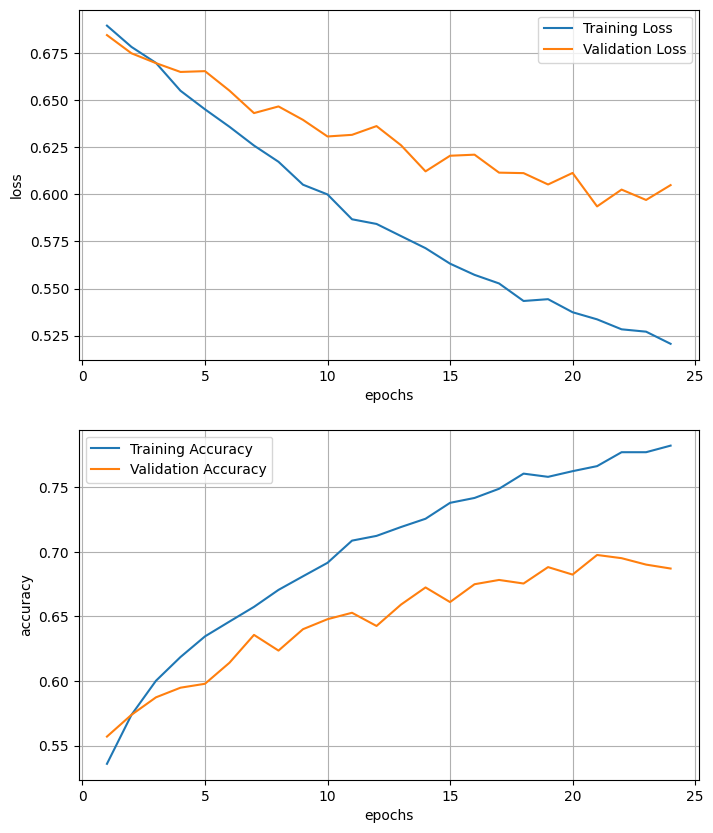

In [9]:
# YOUR CODE HERE
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 10))

ax1.plot(range(1, len(tr_loss) + 1), tr_loss, label='Training Loss')
ax1.plot(range(1, len(te_loss) + 1), te_loss, label='Validation Loss')
#ax1.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')
ax1.set_xlabel('epochs')  # Use set_xlabel instead of xlabel
ax1.set_ylabel('loss')    # Use set_ylabel instead of ylabel
ax1.grid(True)
ax1.legend()

ax2.plot(range(1, len(tr_correct) + 1), tr_correct, label='Training Accuracy')
ax2.plot(range(1, len(te_correct) + 1), te_correct, label='Validation Accuracy')
ax2.set_xlabel('epochs')  # Use set_xlabel instead of xlabel
ax2.set_ylabel('accuracy')  # Use set_ylabel instead of ylabel
ax2.grid(True)
ax2.legend()


2. Comment on line plots.

In [12]:
# YOUR CODE HERE
answer = '''The neural network was trained over 24 epochs.
Overall values show positive trends in both training and testing accuracy as well as loss. 
The training accuracy steadily improved from 53.58% to 78.23%. 
Similarly, testing accuracy increased from 55.69% to nearly 68.71% implying an improvement in model's ability to generalize new data. 
Training loss decreased regularly over epochs from o.69 to 0.52. This shows that the model fitted the training data more effectively. 
In the later epochs: a slight drop in test accuracy and a slight increase in test loss. The steadily improving testing accuracy experienced a minor decline in the final epoch.
Similarly, the decreasing trend in testing loss started to increase slightly towards the end. 
This could be because of the start of overfitting, where the model's performance on unseen data decreases.

'''